#  Mountain Green Cover Index

This notebook calculate the kapos range class for a study area and store the results as a tif file

In [1]:
%matplotlib inline

import os
import datacube
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from scipy.ndimage import uniform_filter, maximum_filter, minimum_filter

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices
from datacube.utils.cog import write_cog
from deafrica_tools.dask import create_local_dask_cluster

from odc.algo import xr_reproject

In [2]:
dc = datacube.Datacube(app="kapos_range")

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:34115 Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [4]:
africa_ds = gpd.read_file('africa_.geojson')
time = '2019'

In [5]:
africa_ds = africa_ds.where(africa_ds['COUNTRY'] == 'Rwanda')

In [6]:
bbox=list(africa_ds.total_bounds)
lon_range = (bbox[0], bbox[2])
lat_range = (bbox[1], bbox[3])

In [7]:
display_map(lon_range, lat_range)

In [8]:
#set up daatcube query object
query = {
    'x': lon_range,
    'y': lat_range,
    'output_crs': 'epsg:6933',
    'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
}

In [9]:
ds = dc.load(product="dem_srtm", resolution=(-1000, 1000), measurements='elevation', **query)

In [10]:
#Implmenting the reducers on the dem results
#var ler = dem.reduceNeighborhood({reducer: ee.Reducer.minMax(), 
#kernel: ee.Kernel.circle({radius:7000, units:’meter’})});

def reduce_nei(da, size, pre):
    img = da.values
    if pre == 'max':
        img = maximum_filter(img, size=size, mode='nearest')
    else:
        img = minimum_filter(img, size=size, mode='nearest')
    
    return img

In [11]:
ds_max = ds.elevation.groupby("time").apply(reduce_nei, size=7, pre='max')
ds_min = ds.elevation.groupby("time").apply(reduce_nei, size=7, pre='min')

In [12]:
ds["ler_range"] = ds_max - ds_min

In [13]:
ds_elevation = dc.load(product="dem_srtm", resolution=(-30, 30), measurements='elevation', **query)

In [14]:
ds = xr_reproject(src=ds, geobox=ds_elevation.geobox,resampling="nearest")

In [15]:
ds_slope = dc.load(product="dem_srtm_deriv", resolution=(-30, 30), measurements='slope', **query)

### Generating Kapos range mountain classess

In [16]:
classess = [0, 1, 2, 3, 4, 5, 6]

elevation = ds_elevation['elevation']
slope = ds_slope['slope']
ler_range = ds['ler_range']

conditions = [
    (elevation < 300),
    (elevation > 4500),
    (elevation >= 3500) & (elevation < 4500),
    (elevation >= 2500) & (elevation < 3500),
    (elevation >= 1500) & (elevation < 2500) & 
        (slope > 2),
    (elevation >= 1000) & (elevation < 1500) & 
        ((slope > 5) | (ler_range > 300)),
    (elevation >= 300) & (elevation < 1000) & (ler_range > 300),
    ]

In [17]:
ds['kapo_class'] = xr.DataArray(np.select(conditions, classess), 
                                coords={'time': ds.time, 'y': ds.y, 'x': ds.x},
             dims=['time', 'y', 'x'])

In [18]:
ds['kapo_class'] = ds['kapo_class'].astype('int8')

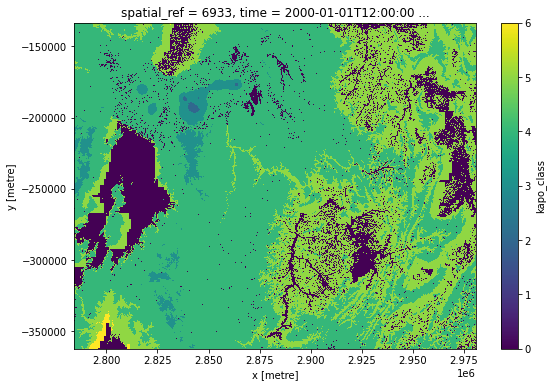

In [19]:
ds['kapo_class'].plot(size=6)

In [20]:
#load the data
ds_cci = dc.load(product='cci_landcover', time=time, measurements='classification',
                  resolution=(-300, 300), **query)

In [21]:
ipcc_classess = ['Forest', 'Cropland', 'Grassland', 'Wetland', 'Other land', 'Settlement']
ipcc_classess_num = [1, 2, 3, 4, 5, 6]

ds_clas = ds_cci['classification']
#IPCC Classification
forest = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100]
cropland = [10, 11, 12, 20, 30, 110]
grassland = [40, 120, 121, 122, 130, 140]
wetland = [160, 170, 180]
otherland = [150, 151, 152, 153, 200, 201, 202, 210, 220]
settlement = [190]

ipcc_condition = [
    ds_clas.isin(forest),
    ds_clas.isin(cropland),
    ds_clas.isin(grassland),
    ds_clas.isin(wetland),
    ds_clas.isin(otherland),
    ds_clas.isin(settlement),
]

In [22]:
ds_cci['ipcc_classification'] = (xr.DataArray(np.select(ipcc_condition, ipcc_classess_num), 
                                   coords={'time': ds_cci.time, 'y': ds_cci.y, 'x': ds_cci.x},
                                   dims=['time', 'y', 'x'])).astype('int8')

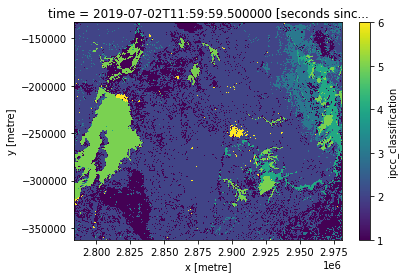

In [23]:
ds_cci['ipcc_classification'].plot()

In [24]:
gng_classess = ['Green', 'Non Green']
gng_classess_num = [1, 2]
recl_condition = [
    ds_cci['ipcc_classification'].isin([1, 2, 3, 4]),
    ds_cci['ipcc_classification'].isin([5, 6]),
]

In [25]:
ds_cci['green_non_green'] = (xr.DataArray(np.select(recl_condition, gng_classess_num), 
                                   coords={'time': ds_cci.time, 'y': ds_cci.y, 'x': ds_cci.x},
                                   dims=['time', 'y', 'x'])).astype('int8')

In [26]:
ds = xr_reproject(src=ds, geobox=ds_cci.geobox)

In [27]:
ds = ds.squeeze()

In [28]:
pixel_length = 300  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

<img align="center" src="img/formulae.png" width=600>

In [29]:
#Total Mountain Area = total area (Km2) of mountains. In both the numerator and
# denominator, Mountain is defined according to Kapos et al. in 2000
total_mountain_area = ds['kapo_class'].where(ds['kapo_class'] != 0).sum(dim=['x', 'y']) * area_per_pixel

In [30]:
mgci = {}
mountain_indices=[y[0] for y in ds.groupby('kapo_class')]
#Mountain Green Cover Area = sum of mountain area (Km2) covered by cropland,
#grassland, forestland, shrubland, and wetland, as defined based on the IPCC classification;
Kapos_filter = (ds['kapo_class'].where(ds_cci['ipcc_classification'].isin([1, 2, 3, 4]), np.nan)
                   ).astype('int8')

for mountain_index in mountain_indices:
    numerator = Kapos_filter.where(Kapos_filter == mountain_index).sum(dim=['x', 'y']) * area_per_pixel
    mgci[mountain_index] = numerator.values / total_mountain_area.values

In [31]:
result = pd.DataFrame.from_dict(mgci,  orient='index', columns=[time])

In [32]:
result

,2019
0,0.000000
2,0.000484
3,0.019742
4,0.584848
5,0.360545
6,0.003231


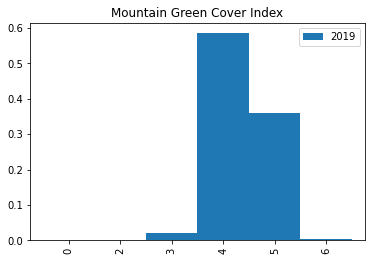

In [33]:
result.plot(kind='bar', width=1)
plt.title('Mountain Green Cover Index')
plt.show()